# Домашнее задание: Обучение и визуализация xLSTM

Цель задания

Обучить простую модель семейства xLSTM для обработки данных, которые были выбраны для обучения Mamba из предыдущего семинара
Визуализировать веса внимания и интерпретировать их
Сделать выводы о том, как модель воспринимает данные и принимает решения и лучше она или хуже Mamba и в чем?

In [1]:
import random, math, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizerFast
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)

In [5]:
RAW_TRAIN = load_dataset("ag_news", split="train[:5000]")
RAW_TEST = load_dataset("ag_news", split="test[:1000]")

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

MAX_LEN = 64
BATCH_SIZE = 32


def encode(batch):
    enc = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )
    enc["labels"] = batch["label"]
    return enc


ENC_TRAIN = RAW_TRAIN.map(encode, batched=True, remove_columns=RAW_TRAIN.column_names)
ENC_TEST = RAW_TEST.map(encode, batched=True, remove_columns=RAW_TEST.column_names)

cols = ["input_ids", "attention_mask", "labels"]
ENC_TRAIN.set_format(type="torch", columns=cols)
ENC_TEST.set_format(type="torch", columns=cols)

train_loader = DataLoader(ENC_TRAIN, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ENC_TEST, batch_size=BATCH_SIZE, shuffle=False)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
class xLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim=128,
                 hidden_dim=256,
                 num_heads=4,
                 n_classes=4,
                 p_drop=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1,
                            batch_first=True, bidirectional=False)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads,
                                          batch_first=True, dropout=p_drop)
        self.fc = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(p_drop)

        # для тепловых карт
        self.last_attention = None

    def forward(self, input_ids, attention_mask, labels=None):
        x = self.embed(input_ids)  # (bs, L, D)
        x, (h_n, _) = self.lstm(x)  # x: (bs, L, H)
        query = h_n[-1].unsqueeze(1)  # (bs, 1, H) — последний hidden
        attn_out, w = self.attn(query, x, x,
                                key_padding_mask=~attention_mask.bool(),
                                need_weights=True)
        self.last_attention = w.detach()  # (bs, 1, L)
        pooled = attn_out.squeeze(1)  # (bs, H)
        logits = self.fc(self.dropout(pooled))  # (bs, n_classes)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return logits, loss

model = xLSTM(len(tokenizer)).to(DEVICE)
print(f"Параметров: {sum(p.numel() for p in model.parameters()) / 1e6:.2f} M")

Параметров: 4.57 M


In [7]:
EPOCHS = 10
LR = 2e-3
CLIP_NORM = 1.0

optim = torch.optim.AdamW(model.parameters(), lr=LR)


def accuracy(pred, labels):
    return (pred.argmax(-1) == labels).float().mean()


for epoch in range(1, EPOCHS + 1):
    model.train()
    t_loss = t_acc = 0.
    for batch in tqdm(train_loader, desc=f"[{epoch}/{EPOCHS}] train"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optim.zero_grad()
        logits, loss = model(**batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optim.step()

        t_loss += loss.item() * len(batch["labels"])
        t_acc += accuracy(logits, batch["labels"]).item() * len(batch["labels"])

    model.eval()
    v_loss = v_acc = 0.
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits, loss = model(**batch)
            v_loss += loss.item() * len(batch["labels"])
            v_acc += accuracy(logits, batch["labels"]).item() * len(batch["labels"])

    n_train = len(ENC_TRAIN);
    n_test = len(ENC_TEST)
    print(f"  loss {t_loss / n_train:.4f} | acc {t_acc / n_train:.4f}  || "
          f"val_loss {v_loss / n_test:.4f} | val_acc {v_acc / n_test:.4f}")

[1/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.8484 | acc 0.6490  || val_loss 0.6764 | val_acc 0.7560


[2/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.3864 | acc 0.8652  || val_loss 0.6009 | val_acc 0.7870


[3/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.2004 | acc 0.9346  || val_loss 0.6754 | val_acc 0.7780


[4/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0959 | acc 0.9728  || val_loss 0.9015 | val_acc 0.7830


[5/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0836 | acc 0.9758  || val_loss 0.8369 | val_acc 0.8010


[6/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0563 | acc 0.9840  || val_loss 0.9480 | val_acc 0.8150


[7/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0440 | acc 0.9870  || val_loss 0.9880 | val_acc 0.7990


[8/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0348 | acc 0.9912  || val_loss 0.9596 | val_acc 0.7970


[9/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0232 | acc 0.9944  || val_loss 1.2094 | val_acc 0.8040


[10/10] train:   0%|          | 0/157 [00:00<?, ?it/s]

  loss 0.0163 | acc 0.9960  || val_loss 1.1084 | val_acc 0.8090


Судя по результатам, видно, что уже к 5-й эпохе модель выучила всё полезное, дальше она зазубривает train.
Идейно early-stopping после 5–6 эпох мог бы сэкономить время на обучение и мы бы избежали роста val loss.


────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Oil Prices Alter Direction After a month-long rally that repeatedly pushed prices to new highs, the cost of a barrel slumped for the fourth day, leaving the price \$10 higher than year-ago rate.

Истинный класс: Business (2)
Предсказанный класс: Business (2)


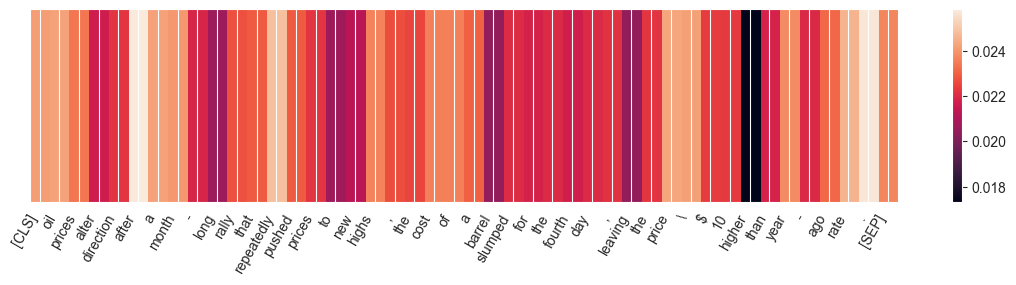

────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Badminton pair want more Nathan Robertson says there is no reason why he and badminton partner Gail Emms should not win the next Olympics.

Истинный класс: Sports (1)
Предсказанный класс: Sports (1)


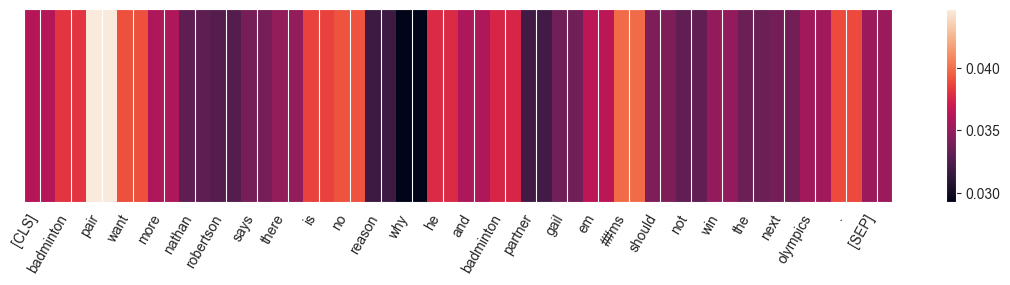

────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Five facts about France #39;s Muslim headscarf ban - The French parliament passed the law in March to ban  quot;conspicuous symbols quot; of faith from its state school system. Guidelines for applying the law identified Muslim headscarves, Jewish skullcaps and large 

Истинный класс: World (0)
Предсказанный класс: Business (2)


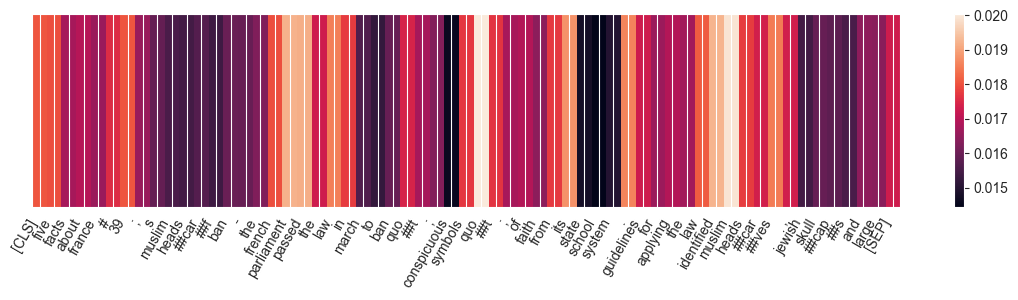

In [26]:
model.eval()

LABEL_NAMES = RAW_TRAIN.features["label"].names  # ['World', 'Sports', 'Business', 'Sci/Tech']


def show_attention(sent=None, idx=None, max_len=MAX_LEN):
    if sent is None:
        if idx is None:
            idx = random.randint(0, len(RAW_TEST) - 1)
        sent = RAW_TEST[idx]["text"]
        true_idx = RAW_TEST[idx]["label"]
        true_label = LABEL_NAMES[true_idx]
    else:
        true_label = None

    enc = tokenizer(
        sent,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    ids, mask = enc["input_ids"].to(DEVICE), enc["attention_mask"].to(DEVICE)

    with torch.no_grad():
        logits, _ = model(ids, mask)
        weights = model.last_attention  # (1, 1, L)
    weights = weights.squeeze(0).squeeze(0)  # (L,)

    seq_len = int(mask.sum())
    weights = weights[:seq_len].cpu()
    tokens = tokenizer.convert_ids_to_tokens(ids[0, :seq_len])

    pred_idx = logits.argmax(-1).item()
    pred_label = LABEL_NAMES[pred_idx]

    print("─" * 100)
    print("Новость:")
    print(sent.replace("\n", " "))
    print()
    if true_label is not None:
        print(f"Истинный класс: {true_label} ({true_idx})")
    print(f"Предсказанный класс: {pred_label} ({pred_idx})")

    plt.figure(figsize=(min(14, 0.6 * seq_len), 2.5))
    plt.imshow(weights.unsqueeze(0), aspect="auto")
    plt.yticks([])
    plt.xticks(range(seq_len), tokens, rotation=60, ha="right")
    plt.colorbar()
    plt.show()

for _ in range(3):
    show_attention()

Первые 2 новости определены верно, с 3 косяк. Разберем каждую отдельно:
1) Главные слова - oil, prices, barrel, cost, higher. То есть модель схватила именно экономические слова, всякие вводные слова без особого смысла не имеют значения.
2) Для новости про спорт главными словами стали Stanley, cup, final, NHL, showdown. Класс тоже определен верно.
3) Здесь модель перепутала world и business, тк слова типа law, ban, guidelines встречались в бизнес-новостях про регуляции.

Сравним с мамбой из предыдущего дз.
xlstm обучился сильно быстрее, чем mamba.
val_accuracy у xlstm чуть выше, но xlstm быстрее переобучается, то есть mamba устойчивей к большему кол-ву эпох.
У мамбы на маленьком датасете качество чуть ниже, но при этом она лучше запоминает длинные зависимости.
